In [1]:
# Set up environment variables
# IMPORTANT: Set these in your .env file or system environment variables before running
# Copy .env.example to .env and fill in your actual API keys
%env OPENROUTER_API_KEY=your_openrouter_api_key_here

env: OPENROUTER_API_KEY=your_openrouter_api_key_here


In [2]:
from datasets import load_dataset, Dataset
import pandas as pd

# Load the Lex Fridman podcast dataset
lex_dataset = load_dataset("RamAnanth1/lex-fridman-podcasts", split="train")

# Convert to pandas DataFrame for easier manipulation
lex_df = lex_dataset.to_pandas()

# The dataset only has "title" and "text" fields, so no grouping is needed
# If there is an "id" or similar, we can keep it, but otherwise just keep title and text
lex_video_df = lex_df[["title", "captions"]].copy()
lex_video_df = lex_video_df.rename(columns={"captions": "text"})
lex_video_df["video_id"] = lex_video_df.index.astype(str)


# Convert back to HuggingFace Dataset
video_dataset = Dataset.from_pandas(lex_video_df, preserve_index=False)
video_dataset


Dataset({
    features: ['title', 'text', 'video_id'],
    num_rows: 319
})

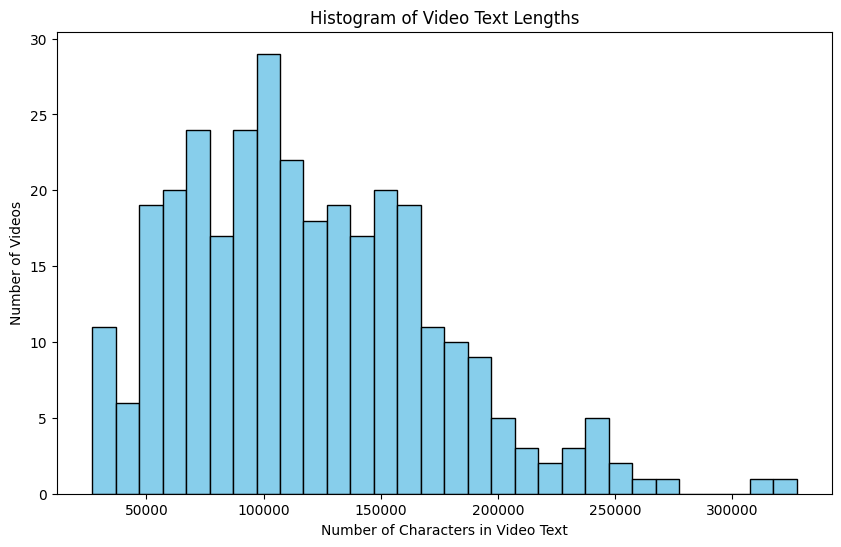

In [3]:
import matplotlib.pyplot as plt

# Compute lengths of each video's text
video_lengths = [len(video['text']) for video in video_dataset]

plt.figure(figsize=(10, 6))
plt.hist(video_lengths, bins=30, color='skyblue', edgecolor='black')
plt.title("Histogram of Video Text Lengths")
plt.xlabel("Number of Characters in Video Text")
plt.ylabel("Number of Videos")
plt.show()


In [4]:
# Only keep rows in video_dataset with text length < 200000
video_dataset = video_dataset.filter(lambda x: len(x['text']) < 200000)
print(f'Length of video_dataset: {len(video_dataset)}')

Filter:   0%|          | 0/319 [00:00<?, ? examples/s]

Length of video_dataset: 297


In [5]:
model_name= "meta-llama/llama-4-scout"

In [8]:
from openai import OpenAI
from os import getenv

client = OpenAI(
    api_key=getenv("OPENROUTER_API_KEY"),
    base_url="https://openrouter.ai/api/v1"
)
def summarize_text(text, model_name):
    response = client.chat.completions.create(
        model=model_name,
        messages=[
            {"role": "system", "content": "You are a helpful assistant that summarizes text in full paragraphs using full sentences without missing any important information."},
            {"role": "user", "content": f"Summarize the following text in as many paragraphs as you need. Capture as much of the text as possible in the summary:\n\n{text}\n\nSummary:"}
        ],
        temperature=1,
    )
    return response

In [9]:
def split_text_into_chunks(text, n=3):
    import re
    # Split text into sentences using regex
    sentences = re.split(r'(?<=[.!?])\s+', text)
    total_sentences = len(sentences)
    chunk_size = total_sentences // n
    chunks = []
    for i in range(n):
        start = i * chunk_size
        # Last chunk takes the remainder
        end = (i + 1) * chunk_size if i < n - 1 else total_sentences
        chunk = ' '.join(sentences[start:end]).strip()
        chunks.append(chunk)
    return chunks

def summarize_text_chain_conversational(text, model_name):
    """
    Splits the text into n=3 chunks, and summarizes each chunk in a conversational chain,
    where each chunk's summary is included in the next prompt as context.
    Finally, asks for a summary of the whole transcript.
    """
    chunks = split_text_into_chunks(text, n=3)
    messages = [
        {"role": "system", "content": "You are a helpful assistant that summarizes text in full paragraphs using full sentences without missing any important information."}
    ]
    chunk_summaries = []
    for i, chunk in enumerate(chunks):
        if i == 0:
            user_prompt = f"Summarize the following part of a transcript:\n\n{chunk}\n\nSummary:"
        else:
            # Add previous summary as context
            prev_summaries = "\n\n".join(
                [f"Summary of part {j+1}:\n{chunk_summaries[j]}" for j in range(i)]
            )
            user_prompt = (
                f"Here is the summary so far:\n{prev_summaries}\n\n"
                f"Now, summarize the next part of the transcript, and update the summary to include all important information from both the previous and new parts. "
                f"Here is the next part:\n\n{chunk}\n\nUpdated summary:"
            )
        messages.append({"role": "user", "content": user_prompt})
        response = client.chat.completions.create(
            model=model_name,
            messages=messages,
            temperature=1,
        )
        summary = response.choices[0].message.content
        chunk_summaries.append(summary)
        # Add assistant's reply to the conversation
        messages.append({"role": "assistant", "content": summary})

    # Final summary prompt
    final_prompt = (
        "Now, based on the conversation so far, write a final, complete summary of the entire transcript, "
        "making sure to include all important information from all parts."
    )
    messages.append({"role": "user", "content": final_prompt})
    final_response = client.chat.completions.create(
        model=model_name,
        messages=messages,
        temperature=1,
    )
    final_summary = final_response.choices[0].message.content
    return {
        "chunk_summaries": chunk_summaries,
        "final_summary": final_summary,
        "final_response": final_response
    }



In [13]:
# Example usage with video_dataset:
chunked_response = summarize_text_chain_conversational(video_dataset[0]['text'], model_name)
print("Chunked summary:")
print(chunked_response['chunk_summaries'])
print("Final summary:")
print(chunked_response['final_summary'])

for key, value in chunked_response['final_response'].usage.__dict__.items():
    print(key, value)


Chunked summary:
['The speaker introduces Max Tegmark, a professor at MIT and physicist who has studied the mysteries of the universe and artificial intelligence. Tegmark is also the co-founder of the Future of Life Institute and has written two books, "Our Mathematical Universe" and "Life3.0". The conversation begins with a question about intelligent life in the universe. Tegmark shares his minority view that there may not be intelligent life elsewhere in the universe, citing the Fermi paradox and the lack of evidence. He suggests that the probability of intelligent life arising on a given planet is low, and that if we assume it\'s equally likely to be any power of 10, then our nearest neighbor could be anywhere from 10 to 16 meters away to 10 to 26 meters away. Tegmark thinks it\'s possible that we are the only life in the universe that has reached the point of building advanced technology, which puts a lot of responsibility on our shoulders.\n\nTegmark discusses the concept of the "

In [14]:
from tqdm import tqdm
all_summaries = []

In [28]:
print(f'Using model {model_name}')
for idx, video in tqdm(enumerate(video_dataset), desc="Summarizing videos", total=len(video_dataset)):
    if idx < len(all_summaries):
        continue
    try:
        summary_response = summarize_text_chain_conversational(video['text'], model_name=model_name)
        all_summaries.append(dict(
                video_id=video['video_id'], title=video['title'],
                chunked_summary = '\n\n'.join(summary_response['chunk_summaries']),
                final_summary = summary_response['final_summary'],
                total_tokens=summary_response['final_response'].usage.total_tokens, 
                prompt_tokens=summary_response['final_response'].usage.prompt_tokens, completion_tokens=summary_response['final_response'].usage.completion_tokens,
                ))
    except Exception as e:
        print(f"Error summarizing video {video['video_id']}: {e}")
        continue


Using model meta-llama/llama-4-scout


Summarizing videos: 100%|██████████| 297/297 [52:32<00:00, 10.62s/it]  


In [29]:
# Convert all_summaries to a pandas DataFrame
import pandas as pd
df = pd.DataFrame(all_summaries)
df.head()

,video_id,title,chunked_summary,final_summary,total_tokens,prompt_tokens,completion_tokens
0,0,Max Tegmark: Life 3.0 | Lex Fridman Podcast #1,"The conversation begins with Max Tegmark, a pr...","The conversation begins with Max Tegmark, a pr...",21256,20054,1202
1,1,Christof Koch: Consciousness | Lex Fridman Pod...,"The conversation begins with Christoph Koch, a...","The conversation begins with Christoph Koch, a...",16917,15817,1100
2,2,Steven Pinker: AI in the Age of Reason | Lex F...,The speaker and Steven Pinker discuss various ...,The speaker and Steven Pinker discuss various ...,12463,11253,1210
3,3,Yoshua Bengio: Deep Learning | Lex Fridman Pod...,The conversation revolves around the differenc...,The conversation revolves around the differenc...,11960,10944,1016
4,4,Vladimir Vapnik: Statistical Learning | Lex Fr...,"The conversation is with Vladimir Vapnik, a re...","The conversation is with Vladimir Vapnik, a re...",13562,12352,1210


In [30]:
import numpy as np
import matplotlib.pyplot as plt
import re

from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

# Load a sentence transformer model from HuggingFace
EMBEDDING_MODEL = "all-MiniLM-L6-v2"
model = SentenceTransformer(EMBEDDING_MODEL, trust_remote_code=True)

In [44]:
all_similarities = []
verbose = False
# Define the specific regex pattern for timestamps
timestamp_pattern = r'(\[\d{2}:\d{2}:\d{2} - \d{2}:\d{2}:\d{2}\])'
# define regex to split by sentence
sentence_pattern = r'(?<=[.!?])\s+'

# Iterate over each video in the video_dataset
for idx, video in tqdm(enumerate(video_dataset), total=len(video_dataset), desc="Calculating similarities"):
    video_id = video['video_id']
    video_title = video['title']
    original_text = video['text']
    # Find the summary for this video_id in df
    summary_row = df[df['video_id'] == video_id]
    if summary_row.empty:
        print(f"Summary for video_id {video_id} not found.")
        continue
    summary = summary_row.iloc[0]['final_summary']  # do this and chunked_summary

    # Chunk into sentences using the specific timestamp pattern
    chunks_A = re.split(sentence_pattern, original_text)
    JOIN_CHUNK_A_SIZE = 10  # join sentences to make chunks_A larger
    chunks_A = [' '.join(chunks_A[i:i+JOIN_CHUNK_A_SIZE]) for i in range(0, len(chunks_A), JOIN_CHUNK_A_SIZE)]
    if verbose:
        print(f'Original words: {len(original_text.split(' '))}. Original chunk size: {len(chunks_A)}')
    chunks_B = re.split(sentence_pattern, summary)  # output of prompt is a summary
    if verbose:
        print(f'Summary words: {len(summary.split(' '))}. Summary chunk size: {len(chunks_B)}')
    try:
        # Get embeddings
        A_embeds = model.encode(chunks_A, convert_to_numpy=True)
        B_embeds = model.encode(chunks_B, convert_to_numpy=True)
        # For each sentence in chunks_B, get cosine similarity to all sentences in chunks_A
        similarities = cosine_similarity(B_embeds, A_embeds)
        all_similarities.append(similarities)
    except Exception as e:
        print(f"Error embedding video {video_id}: {e}")
        continue


Calculating similarities: 100%|██████████| 297/297 [03:09<00:00,  1.57it/s]


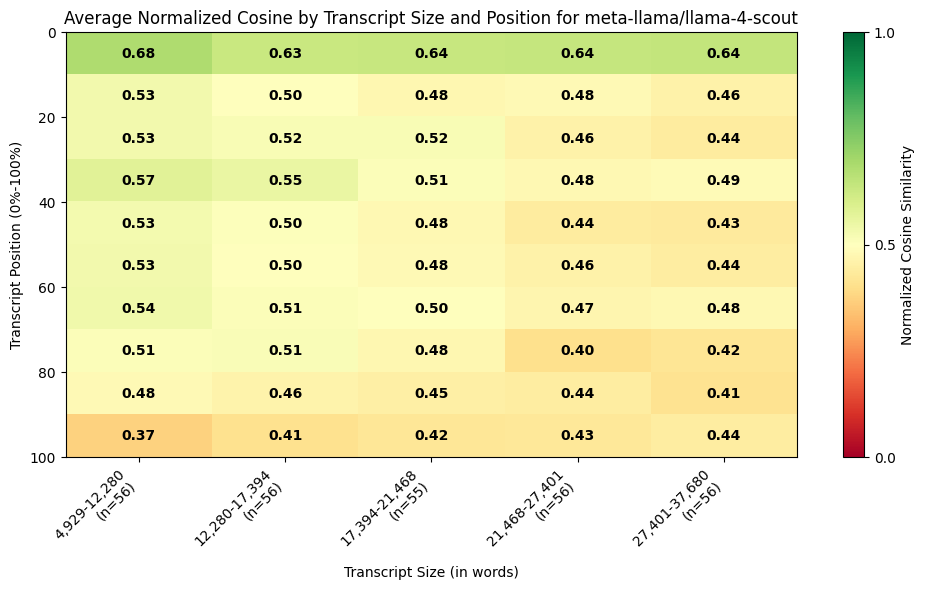

In [45]:
# Bucket videos by their original text length and average similarities within each bucket
import math

# Number of buckets (default 5)
n_buckets = 5

# Get original text length for each video (from df, which has 'text' and 'video_id')
# Build a mapping from video_id to prompt token count (original text length)
video_id_to_prompt_tokens = {v['video_id']: v['text'].count(' ') + 1 for v in video_dataset if int(v['video_id']) in df['video_id']}

# Build a list of (video, text_length, similarity) only for videos that have both text_length and similarity
valid_video_info = []
for i, video in enumerate(video_dataset):
    video_id = video['video_id']
    prompt_tokens = video_id_to_prompt_tokens.get(video_id, None)
    # Only include if prompt_tokens is not None and similarity exists for this index
    if prompt_tokens is not None and i < len(all_similarities):
        similarity = all_similarities[i]
        valid_video_info.append((video, prompt_tokens, similarity))

if not valid_video_info:
    print("No valid videos with both prompt token counts and similarities.")
    # Optionally, exit or skip the rest of the code
else:
    valid_video_dataset = [v[0] for v in valid_video_info]
    valid_prompt_token_counts = [v[1] for v in valid_video_info]
    valid_similarities = [v[2] for v in valid_video_info]

    # Sort by prompt token count for quantile bucketing
    sorted_indices = np.argsort(valid_prompt_token_counts)

    sorted_prompt_tokens = np.array(valid_prompt_token_counts)[sorted_indices]
    sorted_video_dataset = [valid_video_dataset[i] for i in sorted_indices]
    sorted_similarities = [valid_similarities[i] for i in sorted_indices]

    # Compute bucket edges for equal-sized buckets (quantiles)
    total = len(sorted_prompt_tokens)
    bucket_indices = []
    bucket_edges = []
    for b in range(n_buckets):
        start_idx = int(round(b * total / n_buckets))
        end_idx = int(round((b + 1) * total / n_buckets))
        bucket_indices.append(list(range(start_idx, end_idx)))
        if end_idx > 0:
            bucket_edges.append(sorted_prompt_tokens[start_idx])
    # Add the last edge
    bucket_edges.append(sorted_prompt_tokens[-1])

    # For each video, compute normalized similarity vector (as before)
    norm_similarities_list = []
    for similarities in sorted_similarities:
        avg_similarities = np.max(similarities, axis=0)  # shape: (len(chunks_A),)
        norm_similarities_list.append(avg_similarities)

    # To average, we need to interpolate all similarity vectors to the same length (e.g., 100 points)
    interp_len = 10
    norm_similarities_interp = []
    for norm_sim in norm_similarities_list:
        x_old = np.linspace(0, 1, len(norm_sim))
        x_new = np.linspace(0, 1, interp_len)
        norm_sim_interp = np.interp(x_new, x_old, norm_sim)
        norm_similarities_interp.append(norm_sim_interp)

    # Now, for each bucket, average the interpolated similarities
    bucket_avg_similarities = []
    bucket_counts = []
    for b in range(n_buckets):
        idxs = bucket_indices[b]
        if idxs:
            arrs = [norm_similarities_interp[i] for i in idxs]
            avg_arr = np.mean(arrs, axis=0)
            bucket_avg_similarities.append(avg_arr)
            bucket_counts.append(len(idxs))
        else:
            bucket_avg_similarities.append(np.full(interp_len, np.nan))
            bucket_counts.append(0)

    # Plot: each column is a bucket, y-axis is normalized sentence index (0-100%), color is avg similarity
    fig, ax = plt.subplots(figsize=(2 * n_buckets, 6))
    # Stack columns horizontally: shape (interp_len, n_buckets)
    heatmap_data = np.stack(bucket_avg_similarities, axis=1)  # shape: (interp_len, n_buckets)

    # Set up y-axis scaling (0% at top, 100% at bottom)
    y_start, y_end = 100, 0
    extent = [0, n_buckets, y_start, y_end]

    im = ax.imshow(heatmap_data, aspect='auto', cmap='RdYlGn', extent=extent, vmin=0, vmax=1)
    cbar = plt.colorbar(im, ax=ax, label='Normalized Cosine Similarity', ticks=[0, 0.5, 1])
    ax.set_xticks(np.arange(n_buckets) + 0.5)
    # Label buckets by token range
    bucket_labels = []
    for b in range(n_buckets):
        left = int(bucket_edges[b])
        right = int(bucket_edges[b + 1])
        bucket_labels.append(f"{left:,}-{right:,}\n(n={bucket_counts[b]:,})")
    ax.set_xticklabels(bucket_labels, rotation=45, ha='right')
    ax.set_xlabel('Transcript Size (in words)')
    ax.set_ylabel('Transcript Position (0%-100%)')
    ax.set_title(f'Average Normalized Cosine by Transcript Size and Position for {model_name}')
    plt.ylim(y_start, y_end)
    plt.xlim(0, n_buckets)

    # --- Add numbers in each box for color blind accessibility ---
    # We'll annotate each cell with its value, formatted to 2 decimals
    for i in range(interp_len):
        for j in range(n_buckets):
            
            value = heatmap_data[i, j]
            if not np.isnan(value):
                # Calculate the position in data coordinates
                # x: bucket index + 0.5 (center of bucket)
                # y: normalized sentence index (from y_start to y_end, so invert i)
                x = j + 0.5
                y =  (i + 0.5) * (y_start - y_end) / interp_len
                ax.text(
                    x, y, f"{value:.2f}",
                    ha='center', va='center',
                    color='black',
                    fontsize=10, fontweight='bold'
                )

    plt.tight_layout()
    plt.savefig(f"avg_normalized_cosine_similarity_by_prompt_token_bucket_{model_name.replace('/', '_')}_equal_samples final summary.png", dpi=300)
    plt.show()


Shape of heatmap_data for final summary: (10, 5)
Data type: float64
Min value: 0.37285790166684557
Max value: 0.681617486689772
Mean value: 0.4938881698766774
Median value: 0.48126947546342846
Std deviation: 0.0656388961983183
Number of NaNs: 0


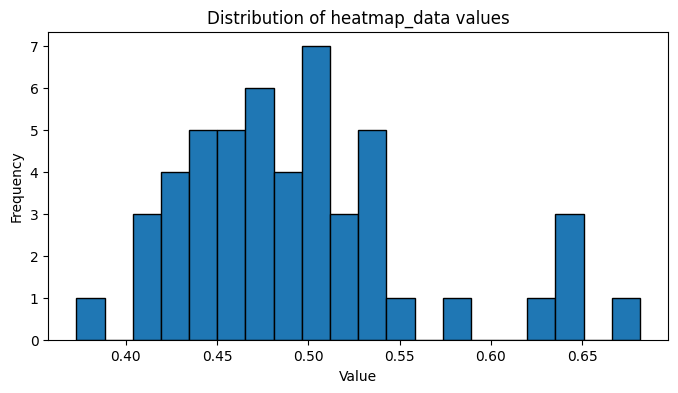

Rows with all NaNs: []
Columns with all NaNs: []


In [46]:
# Exploratory Data Analysis (EDA) of heatmap_data

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

# Basic info
print("Shape of heatmap_data for final summary:", heatmap_data.shape)
print("Data type:", heatmap_data.dtype)

# Summary statistics
print("Min value:", np.nanmin(heatmap_data))
print("Max value:", np.nanmax(heatmap_data))
print("Mean value:", np.nanmean(heatmap_data))
print("Median value:", np.nanmedian(heatmap_data))
print("Std deviation:", np.nanstd(heatmap_data))
print("Number of NaNs:", np.isnan(heatmap_data).sum())

# Distribution of values (flattened, ignoring NaNs)
flat_vals = heatmap_data.flatten()
flat_vals = flat_vals[~np.isnan(flat_vals)]
plt.figure(figsize=(8,4))
plt.hist(flat_vals, bins=20, edgecolor='black')
plt.title("Distribution of heatmap_data values")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()


# Check for any rows or columns with all NaNs
nan_rows = np.where(np.all(np.isnan(heatmap_data), axis=1))[0]
nan_cols = np.where(np.all(np.isnan(heatmap_data), axis=0))[0]
print("Rows with all NaNs:", nan_rows)
print("Columns with all NaNs:", nan_cols)